## Data Preparation

In [1]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

data = pd.read_csv('All_GPUs.csv')

data['Resolution_W'], data['Resolution_H'] = data['Resolution_WxH'].str.split('x').str
data['Core_Speed_MHz'] = data['Core_Speed'].str.replace(' MHz', '')
data['Memory_Speed_MHz'] = data['Memory_Speed'].str.replace(' MHz', '')
data['Max_Power_Watts'] = data['Max_Power'].str.replace(' Watts', '')
data['Release_Price_Dollars'] = data['Release_Price'].str.replace('$', '')
data['Memory_MB'] = data['Memory'].str.replace(' MB', '')
data['Memory_Bus_Bit'] = data['Memory_Bus'].str.replace(' Bit', '')
data['Memory_Bandwidth_GB_Sec'] = data['Memory_Bandwidth'].str.replace('GB/sec', '')

all_features = [
    "Resolution_W",
    "Resolution_H",
    "Core_Speed_MHz",
    "Memory_Speed_MHz",
    "Max_Power_Watts",
    "Release_Price_Dollars",
    "Memory_MB",
    "Memory_Bus_Bit",
    "Memory_Bandwidth_GB_Sec"
]

data = data[all_features].dropna()

for col in data.columns:
    data = data[pd.to_numeric(data[col], errors='coerce').notnull()]
    
data = data.dropna().drop_duplicates().astype('float').astype('int').reset_index(drop=True)

## Selecting Features

In [2]:
columns = ['Resolution_W', 'Memory_Speed_MHz', 'Max_Power_Watts']
features = data[columns].to_numpy()
features

array([[4096, 1750,  375],
       [4096, 1753,  250],
       [4096, 1753,  450],
       ...,
       [4096, 1250,   19],
       [4096,  900,   23],
       [4096,  900,   19]])

Here we select 3 features: the width of the screen resolution, the speed of the GPU memory and the maximal GPU power. Intuitively they should corelate rather well since in order render a higher resolution a GPU needs to have a faster GPU memory, and both rendering and memory management requires power. So maybe the representation of these features could be somehow embedded into a 2D space or approximated by a 1D ranking factor.

## Standardization and Visualization

In [3]:
maximum = features.max(axis=0) 
minimum = features.min(axis=0)
normalized = (features - minimum) / (maximum - minimum)
normalized

array([[0.3       , 0.76828519, 0.61340206],
       [0.3       , 0.77012907, 0.39862543],
       [0.3       , 0.77012907, 0.74226804],
       ...,
       [0.3       , 0.46097111, 0.00171821],
       [0.3       , 0.24585126, 0.00859107],
       [0.3       , 0.24585126, 0.00171821]])

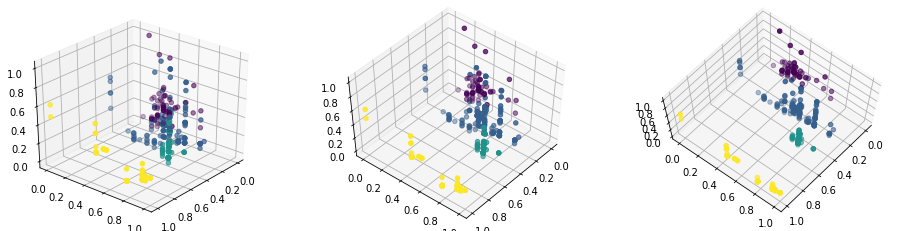

In [4]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(16, 4))
for i, angle in enumerate([30, 50, 70]):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter3D(normalized[:, 0], normalized[:, 1], normalized[:, 2], c=normalized[:, 0])
    ax.view_init(angle, 40)

Colors here show different resolutions

## Data Scatter and SVD

### Firstly for non-normalized data:

In [5]:
print('Not normalized:')
data_scatter = (features ** 2).sum()
print('data_scatter = {}'.format(data_scatter))

Z, mu, C = LA.svd(features)
print('SVD: Z_shape={}, mu_shape={}, C_shape={}'.format(Z.shape, mu.shape, C.shape))

for i in range(len(mu)):
    impact = mu[i] ** 2
    impact_percent = (mu[i] ** 2) * 100 / data_scatter
    print('Component {} impact is {:.2f}, or {:.2f}%'.format(i+1, impact, impact_percent))

Not normalized:
data_scatter = 11310651901
SVD: Z_shape=(390, 390), mu_shape=(3,), C_shape=(3, 3)
Component 1 impact is 11242166483.89, or 99.39%
Component 2 impact is 63915164.01, or 0.57%
Component 3 impact is 4570253.10, or 0.04%


### Then for normalized data:

In [6]:
print('Normalized')
data_scatter = (normalized ** 2).sum()
print('data_scatter = {}'.format(data_scatter))

Z, mu, C = LA.svd(normalized)
print('SVD: Z_shape={}, mu_shape={}, C_shape={}'.format(Z.shape, mu.shape, C.shape))

for i in range(len(mu)):
    impact = mu[i] ** 2
    impact_percent = (mu[i] ** 2) * 100 / data_scatter
    print('Component {} impact is {:.2f}, or {:.2f}%'.format(i+1, impact, impact_percent))

Normalized
data_scatter = 330.2714119493378
SVD: Z_shape=(390, 390), mu_shape=(3,), C_shape=(3, 3)
Component 1 impact is 296.43, or 89.75%
Component 2 impact is 23.50, or 7.11%
Component 3 impact is 10.35, or 3.13%


## Computing a Ranking Factor 

In [7]:
Z, mu, C = LA.svd(normalized)
c0 = C[:, 0]
print('C_0: shape={}, min={}, max={}'.format(c0.shape, np.min(c0), np.max(c0)))
c0 = -c0
z0 = Z[:, 0]
print('Z_0: shape={}, min={}, max={}'.format(z0.shape, np.min(z0), np.max(z0)))
z0 = -z0

C_0: shape=(3,), min=-0.6933203186769367, max=-0.38488285847113946
Z_0: shape=(390,), min=-0.08226828343431929, max=-0.005172039543297234


Here we see that found components are negative, so we change their sign

In [8]:
print('C_0 = {}'.format(c0))
factor_coefficients = c0 / c0.sum()
print('alpha = {:.2f}'.format(1 / c0.sum()))
print('FACTOR = {:.2f}*{} + {:.2f}*{} + {:.2f}*{}'.format(
    factor_coefficients[0], columns[0],
    factor_coefficients[1], columns[1],
    factor_coefficients[2], columns[2],
))

C_0 = [0.60923897 0.69332032 0.38488286]
alpha = 0.59
FACTOR = 0.36*Resolution_W + 0.41*Memory_Speed_MHz + 0.23*Max_Power_Watts


After normalizing the factor coefficients, we found that the hidden factor ranking can be described by the following formula:
$$FACTOR = 0.37 \cdot Resolution\_W + 0.43 \cdot Memory\_Speed + 0.2 \cdot Max\_Power $$
We can also get the vector with the values of the factor for our dataset which will be normalized in [0;1] (or [0%;100%])

Here we can see that in this ranking the maximal power is a mich less important feature than the resolution or memory speed, which is the most important.

In [9]:
FACTOR = 0.37 * normalized[:, 0] + 0.32 * normalized[:, 1] + 0.2 * normalized[:, 2]
print('FACTOR: shape={}, min={:.2f}, max={:.2f}'.format(FACTOR.shape, FACTOR.min(), FACTOR.max()))

FACTOR: shape=(390,), min=0.04, max=0.74


It can be also seen that in this dataset there is no "ideal" sample in terms of our ranking that through combination if its individual features has the highest possible ranking score, and the highest ranked element has its $factor\_score=74\%$

## Visualization with first 2 PC

### Computing Components:

In [10]:
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)
rng  = np.ptp(features, axis=0)

print('std = {}'.format(std))
print('range = {}'.format(rng))
print('\n')

features_z = (features - mean) / std  # Z-scoring
features_range = (features - mean) / rng  # range-scoring


z_Z, z_mu, z_C = LA.svd(features_z)
range_Z, range_mu, range_C = LA.svd(features_range)

print("        z-scored mu:", z_mu)
print("range-normalized mu:", range_mu)

std = [1733.95574515  382.10856739   98.16173775]
range = [5120 1627  582]


        z-scored mu: [25.38000876 19.35541192 12.29728363]
range-normalized mu: [7.45428199 3.37979249 3.21657769]


### Visualization for z-scoring

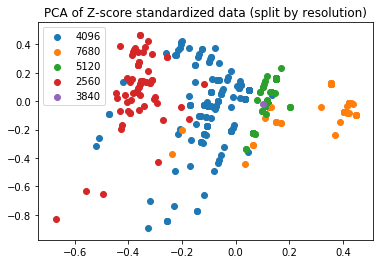

In [11]:
# splitting by resolution
resolution_values = {x for x in data['Resolution_W']}
indices = {res: list(data[data['Resolution_W'] == res].index) for res in resolution_values}


z_z0 = z_Z[:, 0] * np.sqrt(z_mu[0])
z_z1 = z_Z[:, 1] * np.sqrt(z_mu[1])

# plt.scatter(z_z0, z_z1)
for res, index in indices.items():
    plt.scatter(z_z0[index], z_z1[index], label=res)
plt.legend()
plt.title("PCA of Z-score standardized data (split by resolution)")
plt.show()

### Visualization for range-normalization

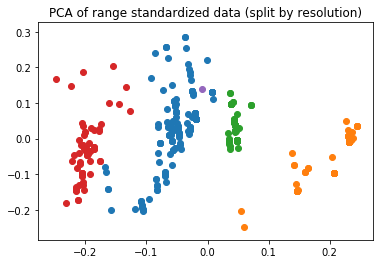

In [12]:
range_z0 = range_Z[:, 0] * np.sqrt(range_mu[0])
range_z1 = range_Z[:, 1] * np.sqrt(range_mu[1])

# plt.scatter(range_z0, range_z1)
for res, index in indices.items():
    plt.scatter(range_z0[index], range_z1[index], label=res)
plt.title("PCA of range standardized data (split by resolution)")
plt.show()

### Visualization for conventional PCA

In [13]:
centered = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
covariance_mat = centered.T @ centered / centered.shape[0]
eigen_numbers, eigen_vectors = LA.eig(covariance_mat)
eigen_order = np.argsort(eigen_numbers)[::-1]
eigen_number_1, eigen_number_2 = eigen_numbers[eigen_order[0]], eigen_numbers[eigen_order[1]]
eigen_vector_1, eigen_vector_2 = eigen_vectors[:, eigen_order[0]], eigen_vectors[:, eigen_order[1]]

In [14]:
Y = centered
principal_vector_1 = Y @ eigen_vector_1.reshape(Y.shape[1], 1) / np.sqrt(Y.shape[0] * eigen_number_1)
principal_vector_2 = - Y @ eigen_vector_2.reshape(Y.shape[1], 1) / np.sqrt(Y.shape[0]  * eigen_number_2)

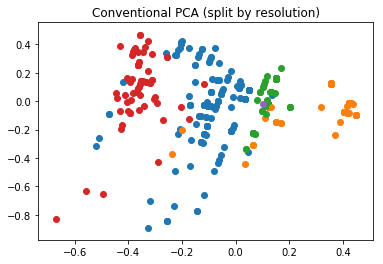

In [15]:
conventional_mu_1 = np.sqrt(Y.shape[0] * eigen_number_1)
conventional_mu_2 = np.sqrt(Y.shape[0] * eigen_number_2)
conventional_z1 = principal_vector_1[:, 0] * np.sqrt(conventional_mu_1)
conventional_z2 = principal_vector_2[:, 0] * np.sqrt(conventional_mu_2)

# plt.scatter(conventional_z1, conventional_z2)
for res, index in indices.items():
    plt.scatter(conventional_z1[index], conventional_z2[index], label=res)
plt.title("Conventional PCA (split by resolution)")
plt.show()

First of all, z-scoring and conventional PCA give us the same visualization. This is because of the fact that these methods produce the same scoring vectors and loadings (except maybe for the sign of the vectors, which can be manually fixed), so it is easy to produce the same visualization.


## Comparison

It can be seen from the plots that range-normalization preserves the structure of the dataset much better than Z-scoring. Mainly, the initial dataset has 4 distinct clusters of samples which show the supported resolution of the GPUs. The second plot (range-normalization) shows these clusters, while at the first plot (z-scoring) the distinction is almost lost.

Mainly it is because of the fact that z-scoring tries to negate the effect of the clusterization (which is meinly determined by "resolution" feature) by dividing it by standard deviation. For z-scoring it greatly affects the resolution feature and lessens its influence. Range-standardization, while still greatly affecting this feature, has a greater effect on other features, which keeps the resolution feature more distinct.